# Image analysis with Gammapy
In this tutorial we'll learn how to use gammapy.StackedObsImageMaker to run image analyses with Gammapy: create counts, background, excess, significance and exposure images

It will use:
- [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html) to load the data to stack in the images
 
- [gammapy.image.SkyMask](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyMask.html) for computing the BKG model 

- [gammapy.image.SkyImage](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html) to create the reference image in which we want to stack the data

- [gammapy.scripts.StackedObsImageMaker](http://docs.gammapy.org/en/latest/api/gammapy.scripts.StackedObsImageMaker.html) to create the images

We use the 4 Crab test runs in gammapy-extra

## Import

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [24]:
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.data import DataStore
from gammapy.image import SkyImage, SkyMask
from gammapy.scripts import StackedObsImageMaker
from gammapy.utils.energy import Energy

## Compute the counts, background, exposure, excess and significance images
Load the data we will stack in the images. Here we take the data from gammapy-extra with the 4 crab runs in which the hdu_table contains a link to a background model.

You can for example take the dataset directory we juste created with the background_model.ipynb notebook with a hdu table that has a link for each run to the background models we just created with this notebook. You just have to replace the dataset_directory by cwd+"/data".

In [25]:
#data_store containing the observations you will stack in the cube
dataset_directory="$GAMMAPY_EXTRA/test_datasets/cube/data"
#cwd= cwd=Path.cwd()
#dataset_directory=str(cwd)+"/data"
data_store = DataStore.from_dir(dataset_directory)

You define the [SkyImage](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html) on which you want to stack the data: center, (x,y) pixels and energy range (here 1-10 TeV)

In [26]:
center = SkyCoord(83.63, 22.01, unit='deg').galactic
energy_band = Energy([1, 10], 'TeV')
#Select the offset band on which you want to select the events in the FOV of each observation
offset_band = Angle([0, 2.49], 'deg')
    
ref_image = SkyImage.empty(nxpix=200, nypix=200, binsz=0.02, xref=center.l.deg,
                               yref=center.b.deg, proj='TAN', coordsys='GAL')


You define an exclusion mask that will be use to create the backgroud 2D map. The background map are normalized on the counts map outside the exclusion region

In [27]:
exclusion_mask = SkyMask.read('$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits')
exclusion_mask = exclusion_mask.reproject(reference=ref_image)

Make the images

In [28]:
# Pb with the load psftable for one of the run that is not implemented yet...
data_store.hdu_table.remove_row(14)

image_maker = StackedObsImageMaker(
        empty_image=ref_image, energy_band=energy_band, offset_band=offset_band, data_store=data_store,
        obs_table=data_store.obs_table, exclusion_mask=exclusion_mask,
    )
image_maker.make_images(make_background_image=True, for_integral_flux=True, radius=4.)
images=image_maker.images

## Images plot

### Counts Image

(<matplotlib.figure.Figure at 0x115114a10>,
 <matplotlib.colorbar.Colorbar at 0x1141a7f50>)

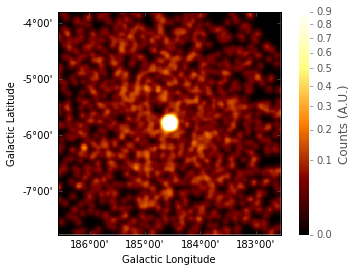

In [29]:
norm = images["counts"].plot_norm(stretch='sqrt', min_cut=0, max_cut=0.9)
images["counts"].smooth(radius=0.08 * u.deg).plot(norm=norm, add_cbar=True)

In [30]:
images["counts"].smooth(radius=0.08 * u.deg).plot

<bound method SkyImage.plot of <gammapy.image.core.SkyImage object at 0x11441cdd0>>

### Background Image

(<matplotlib.figure.Figure at 0x114427190>,
 <matplotlib.colorbar.Colorbar at 0x1160038d0>)

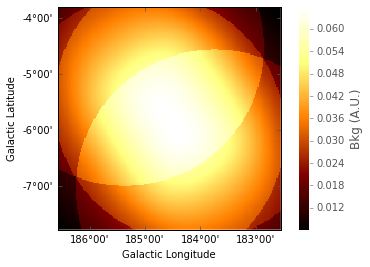

In [31]:
images["bkg"].plot(add_cbar=True)

### Excess Image

(<matplotlib.figure.Figure at 0x114415410>,
 <matplotlib.colorbar.Colorbar at 0x1162b2f90>)

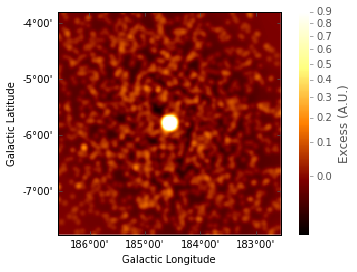

In [32]:
norm = images["excess"].plot_norm(stretch='sqrt', min_cut=0, max_cut=0.9)
images["excess"].smooth(radius=0.08 * u.deg).plot(norm=norm,add_cbar=True)

### Significance Image

(<matplotlib.figure.Figure at 0x116045f50>,
 <matplotlib.colorbar.Colorbar at 0x1165dae10>)

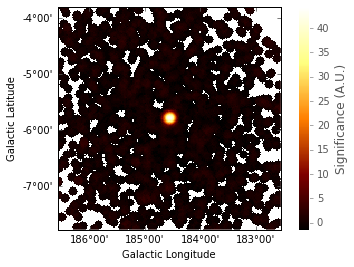

In [33]:
images["significance"].plot(add_cbar=True)

### Exposure Image

(<matplotlib.figure.Figure at 0x11651e050>,
 <matplotlib.colorbar.Colorbar at 0x11682a090>)

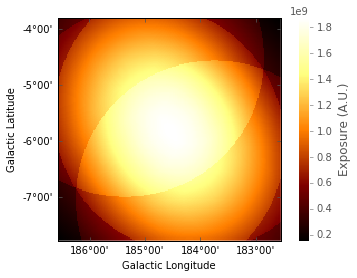

In [34]:
images["exposure"].plot(add_cbar=True)